In [1]:
from copy import deepcopy
from pathlib import Path

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

from netam import framework, models
from netam.common import pick_device, parameter_count_of_model
from netam.framework import load_shmoof_dataframes

In [2]:
shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nickname = 'small'

site_count=500
batch_size=1024
device = pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) #, sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)
    return train_dataset, val_dataset

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 1000

In [4]:
train_dataset_3, val_dataset_3 = data_of_nickname(val_nickname, kmer_length=3)
train_dataset_5, val_dataset_5 = data_of_nickname(val_nickname, kmer_length=5)

train_dataset_3.to(device)
val_dataset_3.to(device)

train_data_by_kmer_length = {
    3: train_dataset_3,
    5: train_dataset_5,
}

val_data_by_kmer_length = {
    3: val_dataset_3,
    5: val_dataset_5,
}
 
model_instances_3 = {
    "cnn_sml": models.CNNModel(kmer_length=3, embedding_dim=6, filter_count=14, kernel_size=7, dropout_rate=0.0),
    "cnn_med": models.CNNModel(kmer_length=3, embedding_dim=9, filter_count=9, kernel_size=11, dropout_rate=0.1),
    "cnn_lrg": models.CNNModel(kmer_length=3, embedding_dim=7, filter_count=19, kernel_size=11, dropout_rate=0.3),
    "cnn_4k": models.CNNModel(kmer_length=3, embedding_dim=12, filter_count=14, kernel_size=17, dropout_rate=0.1),
    "cnn_8k": models.CNNModel(kmer_length=3, embedding_dim=14, filter_count=25, kernel_size=15, dropout_rate=0.0),
    }

model_instances_5 = {
    "fivemer": models.FivemerModel(kmer_length=5),
    "shmoof": models.SHMoofModel(kmer_length=5, site_count=site_count),
}

In [5]:
tang_df = pd.read_csv("/Users/matsen/data/tang-deepshm_size2_edges_22-May-2023.branch_length.csv", index_col=0).reset_index(drop=True)

# only keep rows where parent is different than child
tang_df = tang_df[tang_df["parent"] != tang_df["child"]]
tang_dataset_3 = framework.SHMoofDataset(tang_df, kmer_length=3, site_count=site_count)
tang_dataset_5 = framework.SHMoofDataset(tang_df, kmer_length=5, site_count=site_count)

tang_data_by_kmer_length = {
    3: tang_dataset_3,
    5: tang_dataset_5,
}

In [6]:
def train_or_load(model_name, model, train_dataset, val_dataset, training_params):
    crepe_prefix = f"../pretrained/{model_name}"
    best_val_loss = None

    if framework.does_crepe_exist(crepe_prefix):
        print(f"\tLoading pre-trained {model_name}...")
        crepe = framework.load_crepe(crepe_prefix)
        assert crepe.model.hyperparameters == model.hyperparameters
        return crepe.model

    # else:
    print(f"\tTraining {model_name}...")
    if "cnn" in model_name:
        train_dataset.to(device)
        val_dataset.to(device)
        model.to(device)

    our_burrito_params = deepcopy(burrito_params)
    our_burrito_params.update(training_params)
    burrito = framework.Burrito(train_dataset, val_dataset, model, verbose=False, **our_burrito_params)
    train_history = burrito.train(epochs=epochs)
    # save model to pretrained/ directory
    Path("../pretrained").mkdir(parents=True, exist_ok=True)
    burrito.save_crepe(crepe_prefix)

    return model

In [7]:
def build_model_df(model_instances, train_dataset, val_dataset):
    summary_list = []

    for model_name, model in model_instances.items():
        summary_list.append({
            'model_name': model_name, 
            'model': model, 
            'parameter_count': parameter_count_of_model(model),
            'kmer_length': model.kmer_length,
            'train_dataset': train_dataset,
            'val_dataset': val_dataset,
        })

    return pd.DataFrame(summary_list)

In [8]:
comparison_df = \
    pd.concat([ build_model_df(model_instances_3, train_dataset_3, val_dataset_3),
                build_model_df(model_instances_5, train_dataset_5, val_dataset_5)
            ])
comparison_df["val_nickname"] = val_nickname

comparison_df["training_params"] = [{} for _ in range(len(comparison_df))]
comparison_df.loc[comparison_df["model_name"] == "cnn_lrg", "training_params"] = [{"l2_regularization_coeff": 5e-7}]

for index, row in comparison_df.iterrows():
    model_name = row["model_name"]
    model_instance = row["model"]
    train_dataset = row["train_dataset"]
    val_dataset = row["val_dataset"]
    training_params = row["training_params"]

    trained_model = train_or_load(model_name, model_instance, train_dataset, val_dataset, training_params)
    comparison_df.at[index, "model"] = trained_model

# drop train_dataset and val_dataset columns
comparison_df = comparison_df.drop(columns=["train_dataset", "val_dataset"])
comparison_df
    

	Training cnn_sml...
		{'batch_size': 1024, 'learning_rate': 0.1, 'min_learning_rate': 0.0001, 'l2_regularization_coeff': 1e-06}


Epoch:   4%|▍         | 40/1000 [04:38<1:51:22,  6.96s/it, loss_diff=7.379e-07, lr=3.2e-5]  


	Training cnn_med...
		{'batch_size': 1024, 'learning_rate': 0.1, 'min_learning_rate': 0.0001, 'l2_regularization_coeff': 1e-06}


Epoch:   4%|▎         | 35/1000 [04:52<2:14:30,  8.36s/it, loss_diff=5.517e-07, lr=3.2e-5]  


	Training cnn_lrg...
		{'batch_size': 1024, 'learning_rate': 0.1, 'min_learning_rate': 0.0001, 'l2_regularization_coeff': 5e-07}


Epoch:  10%|█         | 100/1000 [15:23<2:18:31,  9.24s/it, loss_diff=-5.903e-08, lr=3.2e-5]


	Training cnn_4k...
		{'batch_size': 1024, 'learning_rate': 0.1, 'min_learning_rate': 0.0001, 'l2_regularization_coeff': 1e-06}


Epoch:  13%|█▎        | 130/1000 [22:56<2:33:28, 10.58s/it, loss_diff=2.617e-07, lr=3.2e-5]  


	Training cnn_8k...
		{'batch_size': 1024, 'learning_rate': 0.1, 'min_learning_rate': 0.0001, 'l2_regularization_coeff': 1e-06}


Epoch:   7%|▋         | 74/1000 [11:53<2:28:46,  9.64s/it, loss_diff=4.797e-07, lr=3.2e-5]  


	Training fivemer...
		{'batch_size': 1024, 'learning_rate': 0.1, 'min_learning_rate': 0.0001, 'l2_regularization_coeff': 1e-06}


Epoch:   3%|▎         | 29/1000 [00:33<18:41,  1.15s/it, loss_diff=1.031e-07, lr=3.2e-5]  


	Training shmoof...
		{'batch_size': 1024, 'learning_rate': 0.1, 'min_learning_rate': 0.0001, 'l2_regularization_coeff': 1e-06}


Epoch:   4%|▍         | 38/1000 [00:44<18:39,  1.16s/it, loss_diff=-1.331e-07, lr=3.2e-5] 


,model_name,model,parameter_count,kmer_length,val_nickname,training_params
0,cnn_sml,FivemerModel(\n (kmer_embedding): Embedding(1...,1007,3,small,{}
1,cnn_med,SHMoofModel(\n (kmer_embedding): Embedding(10...,1495,3,small,{}
2,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,3,small,{'l2_regularization_coeff': 5e-07}
3,cnn_4k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",3665,3,small,{}
4,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,3,small,{}
0,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,5,small,{}
1,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,5,small,{}


In [25]:
def calculate_loss(model, dataset):
    model.eval()
    model.to(device)
    dataset.to(device)
    burrito = framework.Burrito(dataset, dataset, model, verbose=False, **burrito_params)
    loss = burrito.evaluate()
    return loss

def loss_of_dataset_dict(df, dataset_dict):
    return [
        calculate_loss(row["model"], dataset_dict[row["kmer_length"]])
        for _, row in df.iterrows()
    ]

comparison_df["val_loss"] = loss_of_dataset_dict(comparison_df, val_data_by_kmer_length)
comparison_df["tang_loss"] = loss_of_dataset_dict(comparison_df, tang_data_by_kmer_length)

In [10]:
comparison_df

,model_name,model,parameter_count,kmer_length,val_nickname,val_loss,tang_loss
0,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,3,small,0.055606,0.089671
1,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,3,small,0.055451,0.089609
2,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,3,small,0.055389,0.089357
3,cnn_4k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",3665,3,small,0.055386,0.089764
4,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,3,small,0.055567,0.090053
0,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,5,small,0.055738,0.089919
1,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,5,small,0.055603,0.090088


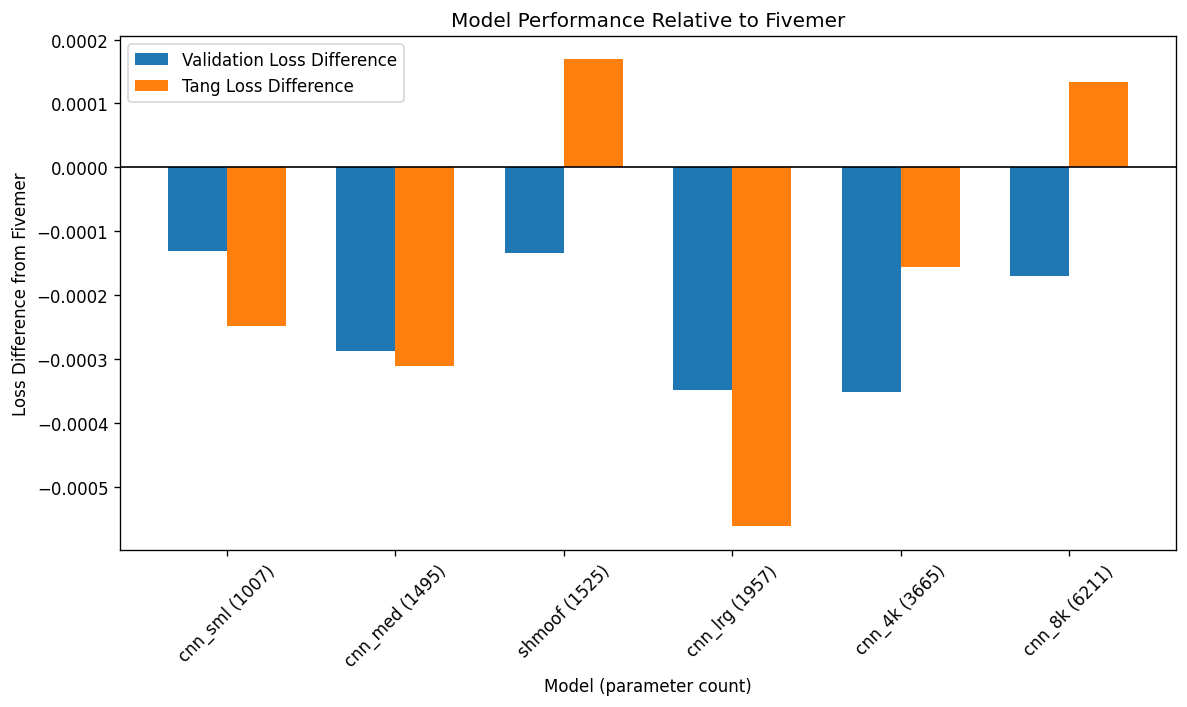

In [11]:
def plot_comparison(df):
    # Calculate the difference from the fivemer model for val_loss and tang_loss
    fivemer_val_loss = df[df['model_name'] == 'fivemer']['val_loss'].values[0]
    fivemer_tang_loss = df[df['model_name'] == 'fivemer']['tang_loss'].values[0]

    df['val_loss_diff'] = df['val_loss'] - fivemer_val_loss
    df['tang_loss_diff'] = df['tang_loss'] - fivemer_tang_loss

    # Filter out the fivemer model and sort by parameter count
    df = df[df['model_name'] != 'fivemer']
    df = df.sort_values(by='parameter_count')

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(df))

    # Creating offset for the second bar
    offset = bar_width / 2

    bar1 = ax.bar(index - offset, df['val_loss_diff'], bar_width, label='Validation Loss Difference')
    bar2 = ax.bar(index + offset, df['tang_loss_diff'], bar_width, label='Tang Loss Difference')

    ax.set_xlabel('Model (parameter count)')
    ax.set_ylabel('Loss Difference from Fivemer')
    ax.set_title('Model Performance Relative to Fivemer')
    ax.legend()
    ax.axhline(0, color='black', linewidth=1)  # Add x-axis line

    # Format x-axis labels with model names and parameter counts
    x_labels = [f"{row['model_name']} ({row['parameter_count']})" for _, row in df.iterrows()]
    plt.xticks(index, x_labels, rotation=45)

    plt.tight_layout()
    plt.show()

plot_comparison(comparison_df)

In [35]:
fivemer_df = comparison_df[comparison_df['model_name'] == 'fivemer']
fivemer_df = fivemer_df[['model_name', 'model', 'parameter_count', 'kmer_length']]
hyperparam_rows = []

for l2_regularization_coeff in [1e-7, 5e-7, 1e-6, 5e-6, 1e-5]:
    for model_name in ['cnn_lrg', 'cnn_4k']:
        my_params = deepcopy(burrito_params)
        my_params['l2_regularization_coeff'] = l2_regularization_coeff
        model = deepcopy(model_instances_3[model_name])
        model.to(device)
        burrito = framework.Burrito(train_dataset_3, val_dataset_3, model, verbose=False, **burrito_params)
        train_history = burrito.train(epochs=100)
        hyperparam_rows.append({
            'model_name': f'{model_name}_l2_{l2_regularization_coeff}',
            'model': model,
            'parameter_count': parameter_count_of_model(model),
            'kmer_length': model.kmer_length,
        })

hyperparam_df = pd.concat([fivemer_df, pd.DataFrame(hyperparam_rows)], ignore_index=True)


Epoch:  32%|███▏      | 32/100 [05:36<11:54, 10.51s/it, loss_diff=-1.18e-06, lr=3.2e-5]  


In [ ]:
hyperparam_df["val_loss"] = loss_of_dataset_dict(hyperparam_df, val_data_by_kmer_length)
hyperparam_df["tang_loss"] = loss_of_dataset_dict(hyperparam_df, tang_data_by_kmer_length)

hyperparam_df

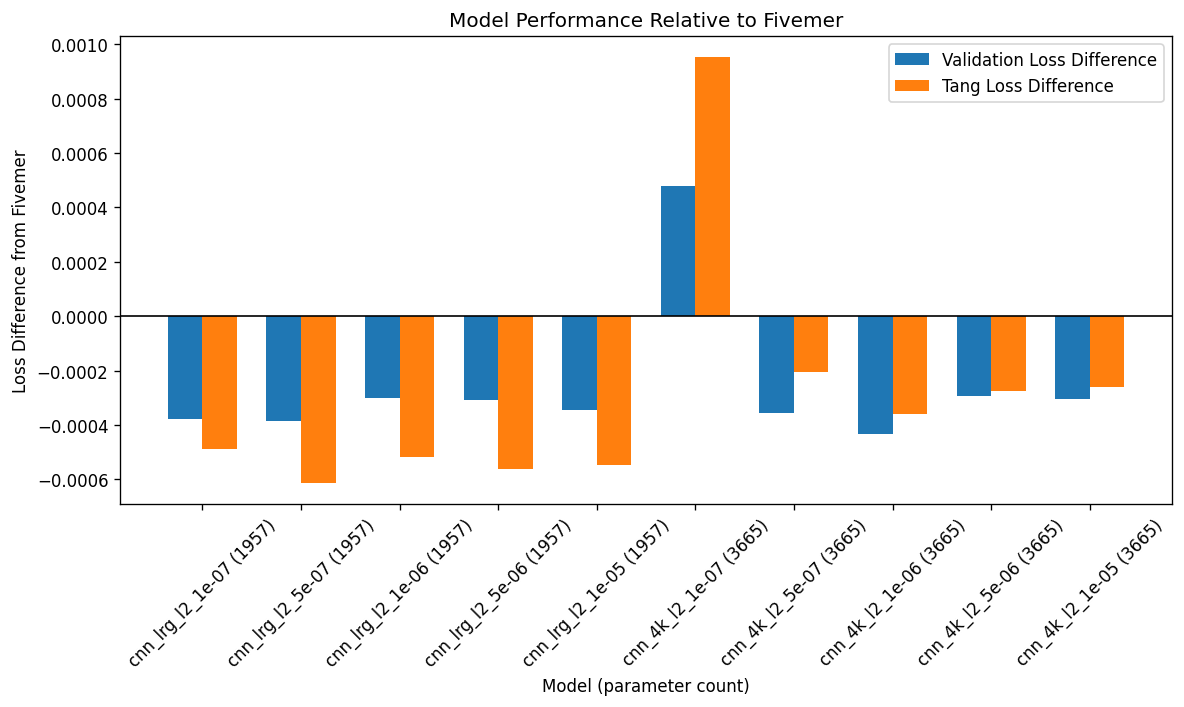

In [42]:
plot_comparison(hyperparam_df)

In [43]:
fivemer_df = comparison_df[comparison_df['model_name'] == 'fivemer']
fivemer_df = fivemer_df[['model_name', 'model', 'parameter_count', 'kmer_length']]
hyperparam_rows = []

for min_learning_rate in [1e-4, 1e-5, 1e-6]:
    for model_name in ['cnn_lrg']:
        my_params = deepcopy(burrito_params)
        my_params['min_learning_rate'] = min_learning_rate
        model = deepcopy(model_instances_3[model_name])
        model.to(device)
        burrito = framework.Burrito(train_dataset_3, val_dataset_3, model, verbose=False, **burrito_params)
        train_history = burrito.train(epochs=100)
        hyperparam_rows.append({
            'model_name': f'{model_name}_min_lr_{min_learning_rate}',
            'model': model,
            'parameter_count': parameter_count_of_model(model),
            'kmer_length': model.kmer_length,
        })

min_lr_df = pd.concat([fivemer_df, pd.DataFrame(hyperparam_rows)], ignore_index=True)


Epoch:  41%|████      | 41/100 [06:24<09:13,  9.38s/it, loss_diff=1.202e-07, lr=3.2e-5]  


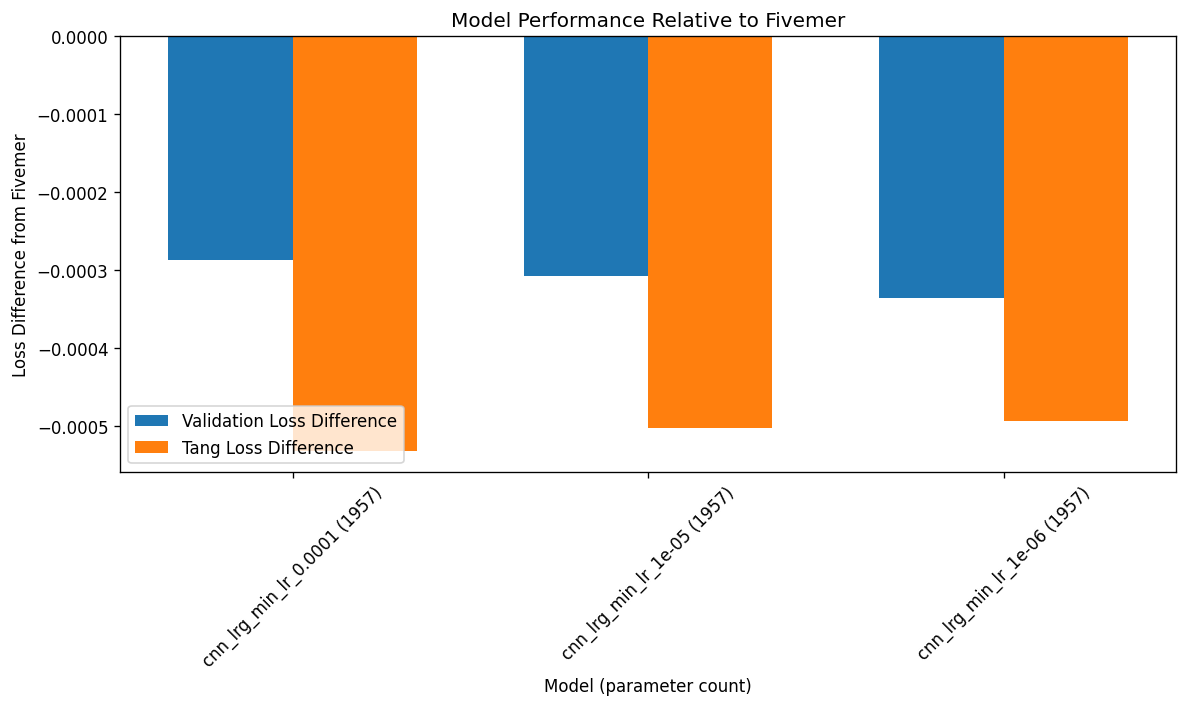

In [44]:
min_lr_df["val_loss"] = loss_of_dataset_dict(min_lr_df, val_data_by_kmer_length)
min_lr_df["tang_loss"] = loss_of_dataset_dict(min_lr_df, tang_data_by_kmer_length)

plot_comparison(min_lr_df)